In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import random

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 500
LR = 1e-3
SEED = 42
torch.manual_seed(SEED)

# --- Convert palette images with transparency to RGB ---
class ToRGB:
    def __call__(self, img):
        if img.mode == 'P':
            img = img.convert('RGBA')
            bg = Image.new("RGB", img.size, (255, 255, 255))
            bg.paste(img, mask=img.split()[3])
            return bg
        elif img.mode != 'RGB':
            return img.convert('RGB')
        return img

# --- Transforms ---
train_tf = transforms.Compose([
    ToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_tf = transforms.Compose([
    ToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# --- Dataset ---
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/emoji_dataset/train', transform=train_tf)
val_dataset   = datasets.ImageFolder('/content/drive/MyDrive/emoji_dataset/val', transform=val_tf)
classes = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- Model ---
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, len(classes))
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Optimizer, Loss, Scheduler ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- CutMix helper ---
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(x.device)
    target_a = y
    target_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, target_a, target_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# --- Training Loop ---
best_val_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        if random.random() < 0.5:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels)
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        total_correct += predicted.eq(labels).sum().item()

    train_loss = total_loss / total
    train_acc = 100. * total_correct / total

    # --- Validation with TTA ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # TTA: original + horizontal flip
            outputs1 = model(inputs)
            flipped_inputs = torch.flip(inputs, dims=[3])
            outputs2 = model(flipped_inputs)
            outputs = (outputs1 + outputs2) / 2

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = 100. * val_correct / val_total
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.3f}, Acc={train_acc:.2f} | Val Loss={val_loss:.3f}, Acc={val_acc:.2f}")

print("Best validation accuracy:", round(best_val_acc, 2), "%")

Epoch   1: Train Loss=5.029, Acc=2.97 | Val Loss=5.733, Acc=4.67
Epoch   2: Train Loss=3.866, Acc=18.90 | Val Loss=8.273, Acc=4.67
Epoch   3: Train Loss=3.415, Acc=28.03 | Val Loss=6.065, Acc=5.61
Epoch   4: Train Loss=3.720, Acc=23.35 | Val Loss=5.124, Acc=7.48
Epoch   5: Train Loss=2.800, Acc=45.01 | Val Loss=5.605, Acc=4.67
Epoch   6: Train Loss=2.789, Acc=45.44 | Val Loss=5.848, Acc=5.61
Epoch   7: Train Loss=2.225, Acc=63.48 | Val Loss=5.748, Acc=5.61
Epoch   8: Train Loss=2.708, Acc=50.32 | Val Loss=5.923, Acc=5.61
Epoch   9: Train Loss=2.019, Acc=71.97 | Val Loss=6.130, Acc=6.54
Epoch  10: Train Loss=2.459, Acc=61.15 | Val Loss=6.179, Acc=6.54
Epoch  11: Train Loss=2.496, Acc=55.20 | Val Loss=6.000, Acc=7.48
Epoch  12: Train Loss=2.256, Acc=60.93 | Val Loss=5.917, Acc=3.74
Epoch  13: Train Loss=2.873, Acc=50.11 | Val Loss=5.671, Acc=5.61
Epoch  14: Train Loss=2.070, Acc=75.80 | Val Loss=5.902, Acc=6.54
Epoch  15: Train Loss=1.774, Acc=78.13 | Val Loss=6.412, Acc=5.61
Epoch  16: 

KeyboardInterrupt: 

<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 129488 (\N{FACE WITH MONOCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 129320 (\N{FACE WITH ONE EYEBROW RAISED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-79ff85c50dfe>:91: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing 

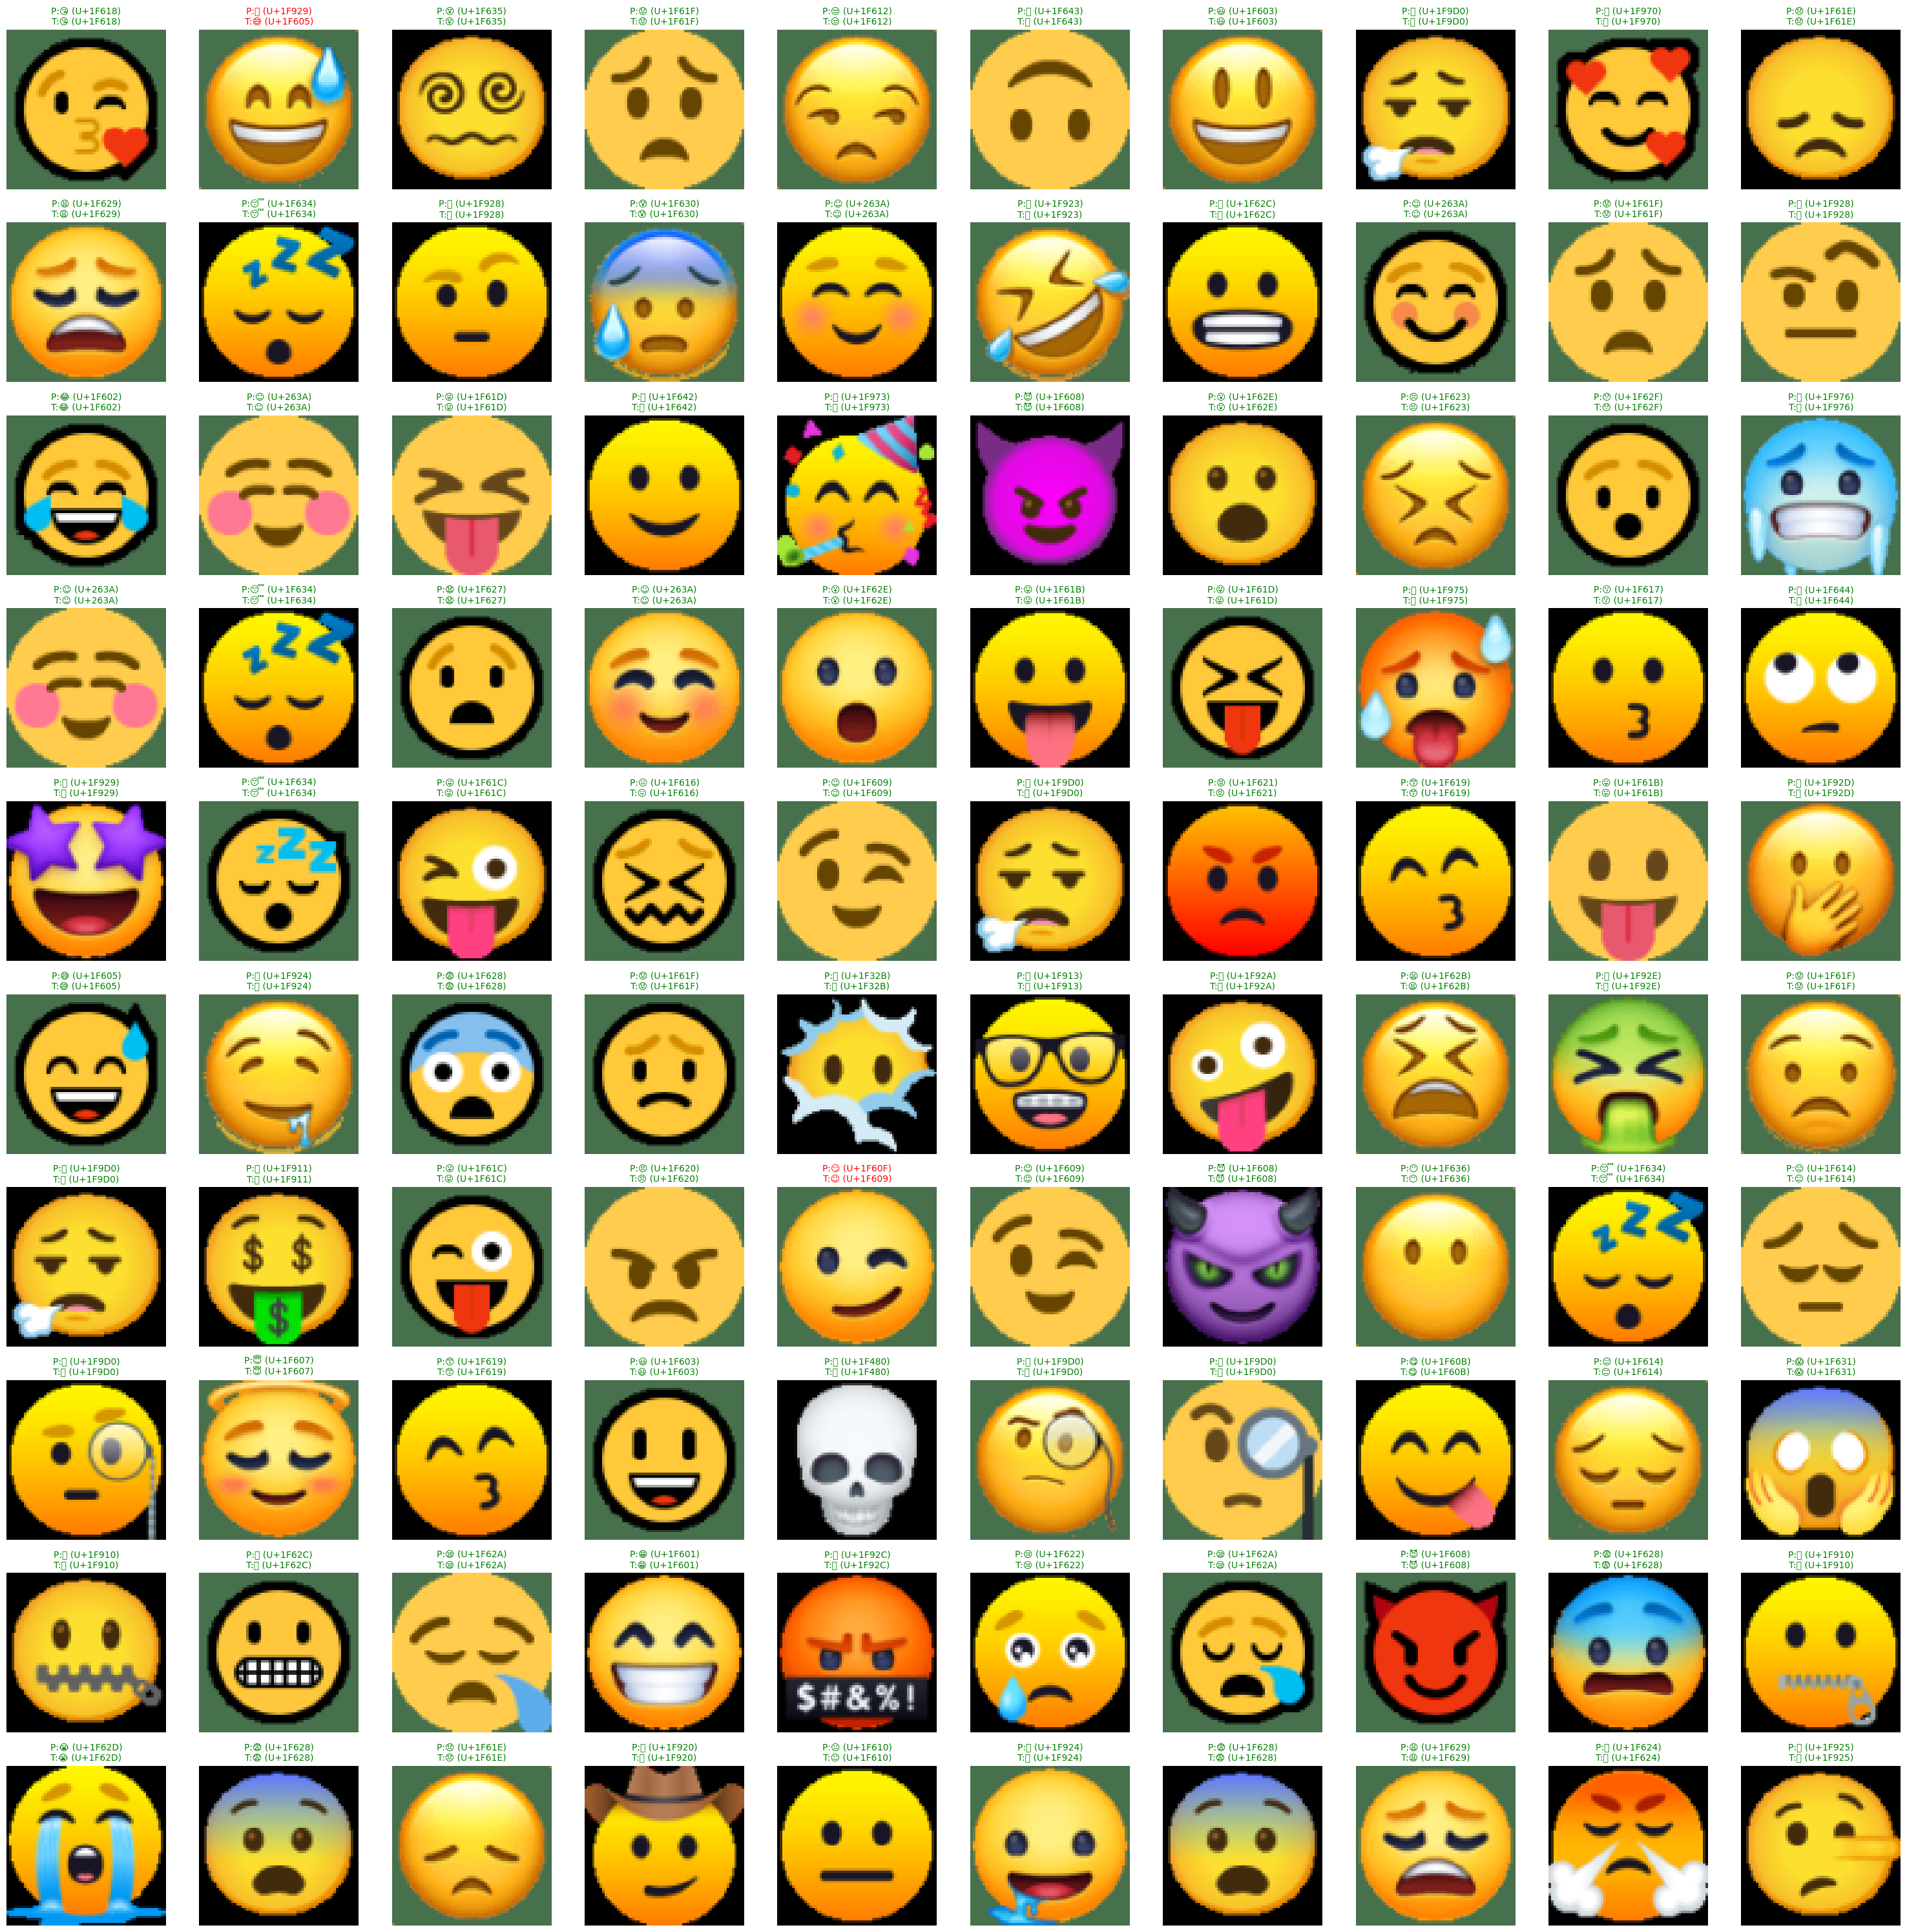

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from PIL import Image
import random
import torch.nn as nn

# --- Configuration ---
IMG_SIZE = 64
DATA_ROOT = '/content/drive/MyDrive/emoji_dataset/train'
MODEL_PATH = 'best_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert palette images with transparency to RGB ---
class ToRGB:
    def __call__(self, img):
        if img.mode == 'P':
            img = img.convert('RGBA')
            bg = Image.new("RGB", img.size, (255, 255, 255))
            bg.paste(img, mask=img.split()[3])
            return bg
        elif img.mode != 'RGB':
            return img.convert('RGB')
        return img

# --- Transforms ---
val_tf = transforms.Compose([
    ToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# --- Dataset ---
val_ds = ImageFolder(DATA_ROOT, transform=val_tf)
class_names = val_ds.classes

# --- Unicode helper ---
def unicode_label(label):
    return chr(int(label.replace("U+", ""), 16))

# --- Load Model ---
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, len(class_names))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# --- Prediction Demo ---
def show_predictions(n=25, cols=5):
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for i in range(n):
        idx = random.randint(0, len(val_ds) - 1)
        img, true_idx = val_ds[idx]

        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            flipped_tensor = torch.flip(input_tensor, dims=[3])
            outputs = model(input_tensor) + model(flipped_tensor)
            pred_idx = outputs.argmax(1).item()

        true_unicode = class_names[true_idx]
        pred_unicode = class_names[pred_idx]

        true_emoji = unicode_label(true_unicode)
        pred_emoji = unicode_label(pred_unicode)

        # Display image
        axes[i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
        title_color = 'green' if true_idx == pred_idx else 'red'

        axes[i].set_title(
            f"P:{pred_emoji} ({pred_unicode})\nT:{true_emoji} ({true_unicode})",
            fontsize=10,
            color=title_color
        )
        axes[i].axis("off")

    # Turn off any unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# --- Run Demo with 25 examples ---
show_predictions(n=100, cols=10)


In [ ]:
!pip install pytesseract
!apt install tesseract-ocr -y  # For Google Colab or Linux

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Saving sample.jpeg to sample (1).jpeg
✅ 14 emojis detected and classified.
📝 Detected Text (including timestamps if any):
 10:13 Fe)
+92 312 4138669 (You)
< 22 Q Message yourself
6:10PM YW
&
6:10PM YH
Hahaha @ ©@ ©@ @ @ Jha dh ahaalhe
wo 10:13PMWY
10:13PM YZ
Lo)
10:13PM Y
10:13PM WV
©
10:13PM WV
aRNe® 10:13PM WZ
+ O Q


<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 129327 (\N{SHOCKED FACE WITH EXPLODING HEAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-dd90ac56b735>:125: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from font(s) DejaVu Sans.
  fi

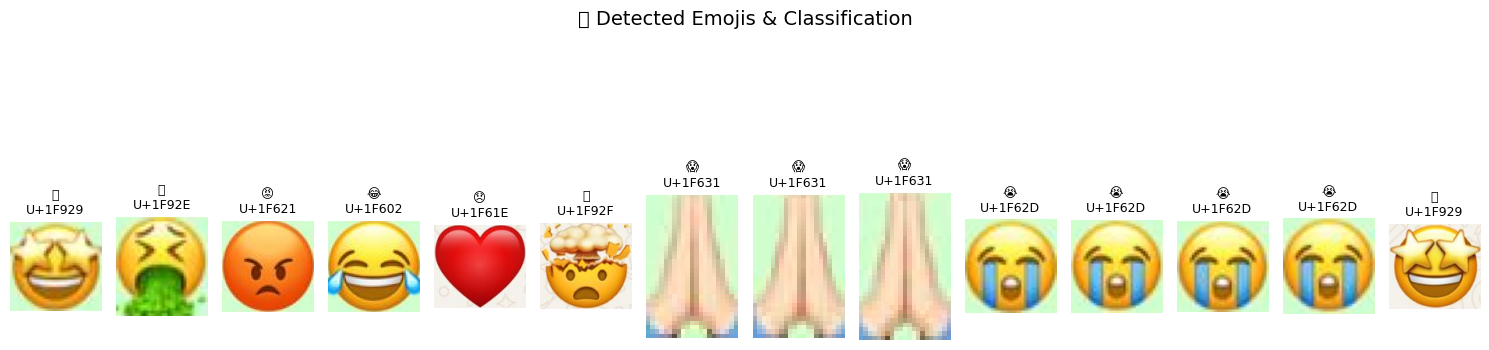

In [ ]:
import cv2, numpy as np, pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import torch, torchvision
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from google.colab import files  # Only for Google Colab
from functools import reduce  # ✅ Required for mask merging

# Configuration
IMG_SIZE = 64
MODEL_PATH = 'best_model.pth'
DATA_ROOT = '/content/drive/MyDrive/emoji_dataset/train'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert palette images with transparency to RGB ---
class ToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGBA').convert('RGB')
        return img

# Transforms
val_tf = transforms.Compose([
    ToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Load class names
val_ds = ImageFolder(DATA_ROOT, transform=val_tf)
class_names = val_ds.classes
def unicode_label(label): return chr(int(label.replace("U+", ""), 16))

# Load trained model
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, len(class_names))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# --- Emoji detection using HSV + roundness ---
def detect_emojis(image_rgb):
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Multiple color ranges for better detection
    masks = []
    color_ranges = [
        ([15, 80, 80], [45, 255, 255]),     # yellow
        ([0, 30, 60], [20, 255, 255]),      # pale skin tones
        ([160, 100, 50], [180, 255, 255])   # pinkish/red emojis
    ]
    for low, high in color_ranges:
        mask = cv2.inRange(hsv, np.array(low), np.array(high))
        masks.append(mask)

    # Merge masks correctly
    full_mask = reduce(cv2.bitwise_or, masks)
    cleaned = cv2.morphologyEx(full_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if w < 20 or h < 20 or area < 300:
            continue
        aspect = w / float(h)
        roundness = 4 * np.pi * area / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
        if 0.6 < aspect < 1.4 and roundness > 0.3:
            boxes.append((x, y, x+w, y+h))
    return boxes

# --- Text extraction using Tesseract ---
def extract_text_data(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(gray, config=custom_config)
    return text.strip()

# --- Main classification function ---
def classify_emojis_and_text(image_path):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    emoji_boxes = detect_emojis(img_rgb)
    text_found = extract_text_data(img_rgb)

    if not emoji_boxes:
        print("❌ No emojis detected.")
    else:
        print(f"✅ {len(emoji_boxes)} emojis detected and classified.")

    if text_found:
        print("📝 Detected Text (including timestamps if any):\n", text_found)
    else:
        print("❌ No text detected.")

    # Draw emoji classification results
    if emoji_boxes:
        plt.figure(figsize=(15, 5))
        for i, (x1, y1, x2, y2) in enumerate(emoji_boxes):
            crop = img_rgb[y1:y2, x1:x2]
            pil_crop = Image.fromarray(crop)
            tensor_img = val_tf(pil_crop).unsqueeze(0).to(device)

            with torch.no_grad():
                flipped = torch.flip(tensor_img, dims=[3])
                logits = model(tensor_img) + model(flipped)
                pred_idx = logits.argmax(1).item()

            pred_unicode = class_names[pred_idx]
            pred_emoji = unicode_label(pred_unicode)

            plt.subplot(1, len(emoji_boxes), i+1)
            plt.imshow(pil_crop)
            plt.title(f"{pred_emoji}\n{pred_unicode}", fontsize=9)
            plt.axis('off')

        plt.suptitle("🔍 Detected Emojis & Classification", fontsize=14)
        plt.tight_layout()
        plt.show()

# --- Upload and classify ---
uploaded = files.upload()
if uploaded:
    image_path = next(iter(uploaded))
    classify_emojis_and_text(image_path)


